In [1]:
# Already done
# pip install transformers==2.9


In [4]:
import torch
import numpy as np
import pandas as pd
import csv

folder_name = "result-bert-large"


In [3]:
sentences_train = []
labels_train = []

tokens = []
token_labels = []
unique_labels_train = set()

with open("corpus-raymond/train-full.txt", newline = '') as lines:                                                                                          
  
    line_reader = csv.reader(lines, delimiter='\t')

    for line in line_reader:
        
        if line == []:

            sentences_train.append(tokens)
            labels_train.append(token_labels)           
    
            tokens = []
            token_labels = []        

        else: 
            #print(str(line[0]))
            tokens.append(line[0])
            token_labels.append(line[1])

            unique_labels_train.add(line[1])

In [4]:
import csv

sentences_dev = []
labels_dev = []
unique_labels_dev = set()

tokens = []
token_labels = []

with open("corpus-raymond/validation-full.txt", newline='', encoding='utf-8') as file:
    line_reader = csv.reader(file, delimiter='\t')

    for line in line_reader:
        # Remove empty spaces and ensure valid parsing
        line = [x.strip() for x in line if x.strip()]  # Strip whitespace & ignore empty columns
        
        if not line:  # If it's an empty line, treat it as a sentence separator
            if tokens:  # Avoid adding empty lists
                sentences_dev.append(tokens)
                labels_dev.append(token_labels)
                tokens, token_labels = [], []  # Reset for next sentence
        else:
            if len(line) == 1 and line[0] == '\"':  # Handle single double-quote case
                tokens.append('\"')
                token_labels.append('O')  # Assuming label should be 'O' if unknown
            elif len(line) >= 2:  # Normal case (word, label)
                tokens.append(line[0])
                token_labels.append(line[1])
                unique_labels_dev.add(line[1])

# Ensure last collected sentence is added
if tokens:
    sentences_dev.append(tokens)
    labels_dev.append(token_labels)


In [5]:
sentences_test = []
labels_test = []

tokens = []
token_labels = []
unique_labels_test = set()

with open("corpus-raymond/validation-full.txt", newline='', encoding='utf-8') as file:
    line_reader = csv.reader(file, delimiter='\t')

    for line in line_reader:
        # Remove empty spaces and ensure valid parsing
        line = [x.strip() for x in line if x.strip()]  # Strip whitespace & ignore empty columns
        
        if not line:  # If it's an empty line, treat it as a sentence separator
            if tokens:  # Avoid adding empty lists
                sentences_test.append(tokens)
                labels_test.append(token_labels)
                tokens, token_labels = [], []  # Reset for next sentence
        else:
            if len(line) == 1 and line[0] == '\"':  # Handle single double-quote case
                tokens.append('\"')
                token_labels.append('O')  # Assuming label should be 'O' if unknown
            elif len(line) >= 2:  # Normal case (word, label)
                tokens.append(line[0])
                token_labels.append(line[1])
                unique_labels_test.add(line[1])

# Ensure last collected sentence is added
if tokens:
    sentences_test.append(tokens)
    labels_test.append(token_labels)

In [6]:
sentences_test[0][:10] # First 10 elements of sentence 1

['the',
 'clinic',
 'basically',
 'schedule',
 'patient',
 ',',
 'provide',
 'service',
 'for',
 'they']

In [7]:
print(labels_test[0][:10]) # First 10 labels of sentence 1

['O', 'O', 'O', 'O', 'B-class', 'O', 'O', 'B-class', 'O', 'O']


In [8]:
# Label values
tag_values = list(unique_labels_train)
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [9]:
## Prepare data for BERT
# Import pytorch and transformers library
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import transformers
from transformers import BertTokenizer, BertConfig

from tensorflow import keras 

from tensorflow.keras.preprocessing.sequence import pad_sequences

torch.__version__

'1.12.1'

In [10]:
# Define BERT parameters
# Sentence length
MAX_LEN = 175
# Batch size
bs = 32 

In [11]:
# CUDA device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
# torch.cuda.get_device_name(0)
# Print state of GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
# Import BERT tokenizer
# Use the BETO model (BERT for Spanish), available in the Transformers library  
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased',use_fast=False)


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/493 [00:00<?, ?B/s]

In [13]:
# Function to tokenize and preserve labels
def tokenize_and_keep_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize each word and count number of its subwords
        # We force conversion to string to avoid errors with float elements
        tokenized_word = tokenizer.tokenize(str(word))
        n_subwords = len(tokenized_word)

        # The tokenized word is added to the resulting tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # The same label is added to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [14]:
tokenized_texts_and_labels_train = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_train, labels_train)
]

In [15]:
tokenized_texts_and_labels_dev = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_dev, labels_dev)
]

In [16]:
tokenized_texts_and_labels_test = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_test, labels_test)
]

In [17]:
tokenized_texts_train = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_train]
labels_train = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_train]

tokenized_texts_dev = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_dev]
labels_dev = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_dev]

tokenized_texts_test = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_test]
labels_test = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_test]

In [18]:
# Padding of sentences according to desired input length
input_ids_train = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_train],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

input_ids_dev = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_dev],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

input_ids_test = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_test],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [19]:
# Paddding of labels with regard to input length
tags_train = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_train],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

tags_dev = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_dev],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

tags_test = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_test],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [20]:
# Create the attention mask to ignore the padded elements in the sequences during training, development and testing
attention_masks_train = [[float(i != 0.0) for i in ii] for ii in input_ids_train]
attention_masks_dev = [[float(i != 0.0) for i in ii] for ii in input_ids_dev]
attention_masks_test = [[float(i != 0.0) for i in ii] for ii in input_ids_test]

In [21]:
# Convert the dataset to torch tensors
train_inputs = torch.tensor(input_ids_train)
dev_inputs = torch.tensor(input_ids_dev)
test_inputs = torch.tensor(input_ids_test)
train_tags = torch.tensor(tags_train)
dev_tags = torch.tensor(tags_dev)
test_tags = torch.tensor(tags_test)
train_masks = torch.tensor(attention_masks_train)
dev_masks = torch.tensor(attention_masks_dev)
test_masks = torch.tensor(attention_masks_test)

In [22]:
# We define the dataloaders. 
# Shuffle the data for training using RandomSampler
train_data = TensorDataset(train_inputs, train_masks, train_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

# Load dev and test data sequentially with SequentialSampler.
dev_data = TensorDataset(dev_inputs, dev_masks, dev_tags)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=bs)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

In [23]:
# The BertForTokenClassification class is used for token-level predictions. 
# It includes the BERT model and carries out token-level classification in the last layer
# We use the Adam optimizer
from transformers import BertForTokenClassification, AdamW 

In [24]:
# Instantiate the model and use the pretrained BETO model (BERT for Spanish)
model = BertForTokenClassification.from_pretrained(
    "bert-large-uncased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large

In [25]:
# Load the model to the GPU
#model.cuda();

In [26]:
# weight_decay is a regularization procedure with regard to the weight matrices
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

# Adam optimizer
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

/anaconda/envs/custom_37/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [27]:
# Import a scheduler to reduce the learning rate 
from transformers import get_linear_schedule_with_warmup

# Number of training epochs; the BERT paper uses 4
epochs = 4
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [28]:
# Import modules to measure the progression of training
# Done
# !pip install seqeval

In [29]:
import seqeval
#from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.metrics import f1_score, classification_report, precision_recall_fscore_support
from tqdm import tqdm, trange

In [30]:
#import wandb
#wandb.login()

In [31]:
#wandb.init(project="pfsa-id-gtx1080ti-bert-v1",entity="sigitpurnomo")

In [32]:
%%time 
# To measure execution time of this cell

# Train the model for; the BERT paper uses 4
## Store the average loss after each epoch; these values are used to plot the loss.
loss_values, development_loss_values = [], []

#data_seqeval = {
#    "predicted_tags": [],
#    "true_tags": [],
#}
#df_seqeval = None

for _ in trange(epochs, desc="Epoch"):
    #
    # Training
    #
    # Set the model into training mode
    model.train()
    # Reset the total loss for each epoch
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        # Transfer batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Remove previous gradients before each backward pass
        model.zero_grad()
        # forward pass
        # This returns the loss (not the model output) since we have input the labels.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # Get the loss
        loss = outputs[0]
        # Backward pass to compute the gradients
        loss.backward()
        # Train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # Update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    

    # Store each loss value for plotting the learning curve afterwards
    loss_values.append(avg_train_loss)

    # After each training epoch, measure performance on development set

    # Set the model into evaluation mode
    model.eval()
    # Reset the development loss for this epoch
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in dev_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # The model must not compute or save gradients, in order to save memory and speed up this step
        with torch.no_grad():
            # Forward pass, compute predictions
            # This will return the logits (logarithm of the odds), not the loss (we do not provide labels)
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Transfer logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Compute the accuracy for this batch of development sentences
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)
        
        #data_seqeval["batch"].append(str(batch))
        #data_seqeval["true_tags"].append(str(label_ids))
        #data_seqeval["predicted_tags"].append(str([list(p) for p in np.argmax(logits, axis=2)]))

    #df_seqeval = pd.DataFrame(data_seqeval)
    #wandb.log({f"dataframe_seqeval": wandb.Table(dataframe=df_seqeval)})
    
    eval_loss = eval_loss / len(dev_dataloader)
    development_loss_values.append(eval_loss)
    print("Development loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    dev_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    f1 = f1_score(pred_tags, dev_tags, average='micro')

    # Format output with 4 decimal places
    output_text = "Test F1 score: {:.4f}".format(f1)

    # Print to console
    print(output_text)

    # Save to a text file
    with open(folder_name + "/f1_score.txt", "a") as file:
        file.write(output_text)
    #print("Development classification report:\n{}".format(classification_report(pred_tags, dev_tags,digits=4)))
    print()
    

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]


Average train loss: 0.6248179120676858
Development F1 score: 0.1455812247891456

Average train loss: 0.2183378434606961
Development loss: 0.16857546120882033
Development F1 score: 0.6824349101576824

Average train loss: 0.10278542339801788
Development loss: 0.12344683110713958
Development F1 score: 0.7847451411807848

Average train loss: 0.07676447156284537


In [33]:
df = pd.DataFrame(list(zip(pred_tags, dev_tags)),
               columns =['Pred', 'True'])

In [34]:
df.to_csv(folder_name+'/train-val-result-bert.csv')

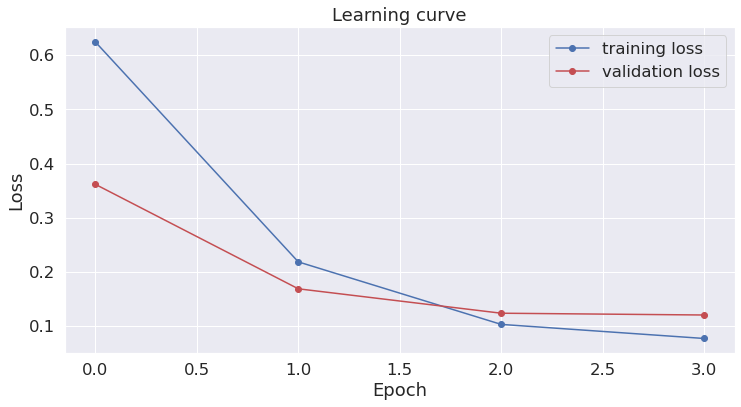

In [35]:
# Plot the training loss
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(development_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [36]:
# Apply the model to the test set
# Set again the model into evaluation mode
model.eval()
nb_eval_steps, nb_eval_examples = 0, 0
predictions , true_labels = [], []

input_ids_list = []

for batch in test_dataloader:

    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # The model must not compute or store gradients
    with torch.no_grad():
        # Forward pass, calculate predictions.
        outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
    # Transfer logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    input_ids_list.extend(b_input_ids)
    
    # Calculate the accuracy for this batch of test sentences
    eval_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
test_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
#print(str(pred_tags))
#print(str(test_tags))
# Compute F1 score
f1 = f1_score(pred_tags, test_tags, average='micro')

# Format output with 4 decimal places
output_text = "Test F1 score: {:.4f}".format(f1)

# Print to console
print(output_text)

# Save to a text file
with open(folder_name + "/f1_score.txt", "\a") as file:
    file.write(output_text)
#print("Test classification report: {}".format(classification_report(pred_tags, test_tags,digits=4)))


print()

Test F1 score: 0.7851118445177852



In [37]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
bert.embeddings.position_ids 	 torch.Size([1, 512])
bert.embeddings.word_embeddings.weight 	 torch.Size([30522, 1024])
bert.embeddings.position_embeddings.weight 	 torch.Size([512, 1024])
bert.embeddings.token_type_embeddings.weight 	 torch.Size([2, 1024])
bert.embeddings.LayerNorm.weight 	 torch.Size([1024])
bert.embeddings.LayerNorm.bias 	 torch.Size([1024])
bert.encoder.layer.0.attention.self.query.weight 	 torch.Size([1024, 1024])
bert.encoder.layer.0.attention.self.query.bias 	 torch.Size([1024])
bert.encoder.layer.0.attention.self.key.weight 	 torch.Size([1024, 1024])
bert.encoder.layer.0.attention.self.key.bias 	 torch.Size([1024])
bert.encoder.layer.0.attention.self.value.weight 	 torch.Size([1024, 1024])
bert.encoder.layer.0.attention.self.value.bias 	 torch.Size([1024])
bert.encoder.layer.0.attention.output.dense.weight 	 torch.Size([1024, 1024])
bert.encoder.layer.0.attention.output.dense.bias 	 torch.Size([1024])
bert.encoder.layer.0.attention.output.Lay

In [38]:
df = pd.DataFrame(list(zip(pred_tags, test_tags)),
               columns =['Pred', 'True'])

In [1]:
df.to_csv(folder_name+'/test-result-bert.csv')

NameError: name 'df' is not defined